In [ ]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>
CUDA_LAUNCH_BLOCKING=1

In [2]:
!pip install torch_audiomentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
from torch_audiomentations import Compose,AddBackgroundNoise , AddColoredNoise , ApplyImpulseResponse,PeakNormalization,TimeInversion

In [4]:
# I had to find the right version of pytorch with the widget here https://pytorch.org/
# I *think* this will work with AWS
#!pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:
# other dependencies
#!pip install timm ipywidgets

In [6]:
## nnAudio
#!pip install git+https://github.com/KinWaiCheuk/nnAudio.git#subdirectory=Installation

### 1 Import the kitchen sink

In [7]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [8]:
# humbug main imports

import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import config
from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd


In [9]:
# humbug lib imports
from sklearn.metrics import accuracy_score
from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm

In [10]:
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as T
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization


In [11]:
## nnAudio
from nnAudio import features
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

In [12]:
#Global Training variables 
num_workers=4
pin_memory=True
#train_size = 100
batch_size = 128
test_batch_size = 128
DEBUG = False
if DEBUG:
    batch_size = 4
    test_batch_size = 4
    num_workers=1
    
     

num_epochs = 100

### Run all these function definition cells
These have been extracted from the lib folder and are here to make them more easily editable.  Most of the action happens in *get_feat_torch*, which does feature extraction and *train_model*

In [13]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    for _,row in df.iterrows():
        if row['length'] > min_length:
            step_size = step_frac*min_length
            audio_offsets.append({'id':row['id'], 'offset':0, 'length': row['length'],'specie_ind': row['specie_ind']})
            for i in range(1, int((row['length']-min_length)//step_size)):
                audio_offsets.append({'id': row['id'], 'offset':int(min_length+(i*step_size)*config.rate), 'length': row['length'],'specie_ind': row['specie_ind']})
        elif short_audio:
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind']})
    return pd.DataFrame(audio_offsets)       

In [14]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' , 'others']
classes_no_other = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]
other_ind = classes.index('others')

### Read CSV and get train/test groups

In [15]:
if DEBUG:
    df = pd.read_csv(config.data_df_msc_test)
else:
    df = pd.read_csv(config.data_df)

#df = df.loc[df['Grade'].notnull()]
df = df.loc[df['species'].notnull()]
df

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
1,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
2,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
3,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
4,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
5,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9000,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9009,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup
9011,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup


In [16]:
# adding a colum for specie encoding
df['specie_ind'] = "NULL_VAL"

    

In [17]:
# Adding a new column to encode specie_index in the same order as the list "classes"
ind = 0
for specie in classes_no_other:
    print("specie = " + str(specie) + "and its index = " + str(ind) )
    row_indexes=df[df['species']==specie].index 
    df.loc[row_indexes,'specie_ind']= ind
    ind+=1

    
other_df_ind = df[df['specie_ind'] == "NULL_VAL"].index
df.loc[other_df_ind,'specie_ind']= other_ind                  

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7


In [18]:
len(df)

6008

In [19]:
USE_SHORT_AUDIO = True

In [20]:
#Test should happen on Cup and Tanzania
idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_tz_cup = df[idx_multiclass]

In [21]:
df_tz_cup.reset_index(inplace = True)
df_tz_cup.drop('index',axis = 1)
df.reset_index(inplace = True)
df.drop('index',axis = 1)

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6004,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6005,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
6006,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [22]:
#https://stackoverflow.com/questions/18180763/set-difference-for-pandas
df_temp = pd.concat([df, df_tz_cup, df_tz_cup]).drop_duplicates(keep=False)

### Verifying that the temp data does not have any test leakage

In [23]:
#np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
df_temp[(np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup'))].sum()
#df_temp([df_temp['country'] == 'Tanzania' and df_temp['location_type'] == 'cup'])

index              0.0
id                 0.0
length             0.0
name               0.0
sample_rate        0.0
record_datetime    0.0
sound_type         0.0
species            0.0
gender             0.0
fed                0.0
plurality          0.0
age                0.0
method             0.0
mic_type           0.0
device_type        0.0
country            0.0
district           0.0
province           0.0
place              0.0
location_type      0.0
specie_ind         0.0
dtype: float64

In [24]:
df_temp.reset_index(inplace = True)
df_temp.drop('index',axis = 1,inplace = True)
df_temp.drop('level_0',axis = 1,inplace = True)

In [25]:
df_temp

,id,length,name,sample_rate,record_datetime,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type,specie_ind
0,53,0.463456,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
1,57,0.170249,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
2,61,0.104041,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
3,69,0.274290,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Single,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
4,56,0.420894,CDC_Ae-aegypti_labelled_800.wav,8000,08-09-16 08:00,mosquito,ae aegypti,NaN,NaN,Plural,NaN,NaN,phone,Alcatel 4009X,USA,Georgia,Atlanta,"CDC insect cultures, Atlanta",culture,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454,3562,6.083093,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3455,3556,6.719908,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3456,3553,6.128580,#988-1001.wav,44100,01-07-18 12:00,mosquito,an maculatus,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8
3457,3561,11.614280,#988-1001.wav,44100,01-07-18 12:00,mosquito,an harrisoni,Female,t,Single,NaN,ABN,telinga,olympus,Thailand,Sai Yok District,Kanchanaburi Province,field site near Pu Teuy Village,cup,8


In [26]:
print("len of df_temp = " + str(len(df_temp)))
print("len of df_tz_cup = " + str(len(df_tz_cup)))
print("len of df = " + str(len(df)))
if (len(df) == len(df_tz_cup) + len(df_temp)):
    print("split successful")
else:
    print("split error")

len of df_temp = 3459
len of df_tz_cup = 2549
len of df = 6008
split successful


### Before we start training we need to also have some samples from tz_cup in training

In [27]:
df_tz_cup_samp = df_tz_cup.sample(frac = .8 , random_state = 42)
print("length of df_tz_cup_samp = " + str(len(df_tz_cup_samp)))

length of df_tz_cup_samp = 2039


In [28]:
df_test = pd.concat([df_tz_cup, df_tz_cup_samp, df_tz_cup_samp]).drop_duplicates(keep=False)

In [29]:
len(df_test)

510

Add some TZ_cup sampled to the Training data

In [30]:
temp_train_frame = [df_temp , df_tz_cup_samp]
df_temp_train = pd.concat(temp_train_frame)
print("length of concatenated frame = " + str(len(df_temp_train)))

length of concatenated frame = 5498


### Finally a train-val split

In [31]:
from sklearn.model_selection import train_test_split
# avoiding train test split and using the same logic as in original Humbug paper
# train_recordings[i] =  shuffle(pd.unique(df_class.name), random_state=random_seed)[:n_train]  
#test_recordings[i] = shuffle(pd.unique(df_class.name),random_state=random_seed)[n_train:]
#df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
msk = np.random.rand(len(df_temp_train)) < 0.8
df_train = df_temp_train[msk]
df_val  = df_temp_train[~msk]

In [32]:
print("length of train = " + str(len(df_train)))
print("length of val = " + str(len(df_val)))


length of train = 4393
length of val = 1105


In [33]:
df_train_offset = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
df_test_offset = get_offsets_df(df_test, short_audio=USE_SHORT_AUDIO)
df_val_offset = get_offsets_df(df_val, short_audio=USE_SHORT_AUDIO)

In [34]:
print("length of train offset = " +str(len(df_train_offset)))
print("length of test offset = " +str(len(df_test_offset)))
print("length of val offset = " +str(len(df_val_offset)))

length of train offset = 103845
length of test offset = 23294
length of val offset = 24673


In [35]:
# from sklearn.model_selection import train_test_split

# df_train_offset_temp,df_test_offset  = train_test_split(df_offset, test_size=0.2,random_state = 152)
# df_train_offset,df_val_offset  = train_test_split(df_train_offset_temp, test_size=0.2)


In [36]:
# for i in range(0,len(classes)):
#     df_temp = df_val_offset[df_val_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))

In [37]:
#df_temp.reset_index(inplace = True)
df_train_offset.reset_index(inplace = True)
df_test_offset.reset_index(inplace = True)
df_val_offset.reset_index(inplace = True)



In [38]:
def get_specie_distri(df , classes , type_df = None):
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))
    
    

In [39]:
#class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(y_train_CNN)),y=np.array(y_train_CNN))
np.array(df_train_offset.specie_ind)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df_train_offset.specie_ind)),y=np.array(np.array(df_train_offset.specie_ind)))
print(class_weights)

[0.38041388 0.81983326 4.12672866 0.7857759  3.30516566 7.10488506
 4.02312878 7.91924045 0.3548073 ]


In [40]:
len(df_val_offset)

24673

In [41]:
#get_specie_distri(df_train_offset , classes , type_df = "train")
#get_specie_distri(df_val_offset , classes , type_df = "Val")
get_specie_distri(df_test_offset , classes , type_df = "test")

DF type = test
i = 0
9018
DF type = test
i = 1
4157
DF type = test
i = 2
429
DF type = test
i = 3
3422
DF type = test
i = 4
1327
DF type = test
i = 5
657
DF type = test
i = 6
975
DF type = test
i = 7
423
DF type = test
i = 8
2886


In [42]:
### get the frame offsets for each audio file into dataframes
# audio_df_train = get_offsets_df(df_train, short_audio=USE_SHORT_AUDIO)
# audio_df_test_A = get_offsets_df(df_test_A, short_audio=False)
# audio_df_test_B = get_offsets_df(df_test_B, short_audio=False)

In [43]:
# This function pads a file with 0s to make it a 1.92 sec file
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)

In [44]:
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(0,9))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()
    
    
    

In [45]:
#check the min length based on config params
min_length = (config.win_size * config.n_hop) / config.rate
min_length

1.92

### Class Defintions

In [46]:
class Normalization():
    """This class is for normalizing the spectrograms batch by batch. The normalization used is min-max, two modes 'framewise' and 'imagewise' can be selected. In this paper, we found that 'imagewise' normalization works better than 'framewise'"""
    def __init__(self, mode='framewise'):
        if mode == 'framewise':
            def normalize(x):
                size = x.shape
                x_max = x.max(1, keepdim=True)[0] # Finding max values for each frame
                x_min = x.min(1, keepdim=True)[0]  
                output = (x-x_min)/(x_max-x_min) # If there is a column with all zero, nan will occur
                output[torch.isnan(output)]=0 # Making nan to 0
                return output
        elif mode == 'imagewise':
            def normalize(x):
                size = x.shape
                x_max = x.reshape(size[0], size[1]*size[2]).max(1, keepdim=True)[0]
                x_min = x.reshape(size[0], size[1]*size[2]).min(1, keepdim=True)[0]
                x_max = x_max.unsqueeze(1) # Make it broadcastable
                x_min = x_min.unsqueeze(1) # Make it broadcastable 
                return (x-x_min)/(x_max-x_min)
        else:
            print(f'please choose the correct mode')
        self.normalize = normalize

    def __call__(self, x):
        return self.normalize(x)

In [47]:
def pcen(x, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, training=False):
    frames = x.split(1, -2)
    m_frames = []
    last_state = None
    for frame in frames:
        if last_state is None:
            last_state = s * frame
            m_frames.append(last_state)
            continue
        if training:
            m_frame = ((1 - s) * last_state).add_(s * frame)
        else:
            m_frame = (1 - s) * last_state + s * frame
        last_state = m_frame
        m_frames.append(m_frame)
    M = torch.cat(m_frames, 1)
    if training:
        pcen_ = (x / (M + eps).pow(alpha) + delta).pow(r) - delta ** r
    else:
        pcen_ = x.div_(M.add_(eps).pow_(alpha)).add_(delta).pow_(r).sub_(delta ** r)
    return pcen_


class PCENTransform(nn.Module):

    def __init__(self, eps=1e-6, s=0.025, alpha=0.98, delta=2, r=0.5, trainable=True):
        super().__init__()
        if trainable:
            self.log_s = nn.Parameter(torch.log(torch.Tensor([s])))
            self.log_alpha = nn.Parameter(torch.log(torch.Tensor([alpha])))
            self.log_delta = nn.Parameter(torch.log(torch.Tensor([delta])))
            self.log_r = nn.Parameter(torch.log(torch.Tensor([r])))
        else:
            self.s = s
            self.alpha = alpha
            self.delta = delta
            self.r = r
        self.eps = eps
        self.trainable = trainable

    def forward(self, x):
#         x = x.permute((0,2,1)).squeeze(dim=1)
        if self.trainable:
            x = pcen(x, self.eps, torch.exp(self.log_s), torch.exp(self.log_alpha), torch.exp(self.log_delta), torch.exp(self.log_r), self.training and self.trainable)
        else:
            x = pcen(x, self.eps, self.s, self.alpha, self.delta, self.r, self.training and self.trainable)
#         x = x.unsqueeze(dim=1).permute((0,1,3,2))
        return x

In [48]:
df_train_offset.head()

,index,id,offset,length,specie_ind
0,0,53,0,0.463456,2
1,1,57,0,0.170249,2
2,2,61,0,0.104041,2
3,3,69,0,0.274290,2
4,4,56,0,0.420894,2


In [49]:
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x)['prediction']
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
    
    
    return test_loss, test_acc , all_y,all_y_pred

In [50]:
#(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )
def train_model(train_loader, val_loader,test_loader, model = None,  classes = classes,class_weights = class_weights,num_epochs = num_epochs ,n_channels = 1):
    # Creates a GradScaler once at the beginning of training.
    loss_scaler = NativeScaler()
    global_step = 0
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_adj)
    optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_acc = []
    all_val_loss = []
    all_val_acc = []
    best_val_loss = np.inf
    best_val_acc = -np.inf
    best_train_acc = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    lr_log = []
    for e in range(num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(tk0):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 200 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            y = inputs[1].type(torch.LongTensor).to(device)
            global_step += 1
            optimiser.zero_grad()
            # AMP
            with autocast():
                y_pred = model(x)['prediction']
                preds = torch.argmax(y_pred, axis = 1)
                if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
                loss = criterion(y_pred, y)
            loss_scaler(loss, optimiser,parameters=model_parameters(model))
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            all_y_pred.append(preds.cpu().detach())
            lr_log.append(optimiser.param_groups[0]['lr'])
            tk0.set_postfix(training_loss=(train_loss / (batch_i+1)), lr=optimiser.param_groups[0]['lr'])
            del x
            del y
            del y_pred,preds
        
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_acc = accuracy_score(all_y.numpy(), all_y_pred.numpy())
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_acc.append(train_acc)
        val_loss, val_acc , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        if DEBUG:
            print("val accuracy = " + str(val_acc))
        all_val_loss.append(val_loss)
        all_val_acc.append(val_acc)
        
        acc_metric = val_acc
        best_acc_metric = best_val_acc
        if acc_metric > best_acc_metric:  
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir, 'pytorch', checkpoint_name))
            print('Saving model to:', os.path.join(config.model_dir, 'pytorch', checkpoint_name)) 
            print("Now printing classification rport... ")
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_acc = val_acc
            best_val_loss = val_loss
            overrun_counter = -1
        overrun_counter += 1
        print('Epoch: %d, Train Loss: %.8f, Train Acc: %.8f, Val Loss: %.8f, Val Acc: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_acc, val_loss/len(val_loader), val_acc,  overrun_counter))
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log

In [51]:
from torch_audiomentations import Compose, Gain, PolarityInversion,AddColoredNoise,ApplyImpulseResponse,PeakNormalization
#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])


apply_augmentation = Compose(
    transforms=[AddColoredNoise(p = 1)  ])

#apply_augmentation = Compose(transforms=[PolarityInversion(p=0.5 ,output_type = 'tensor'),AddColoredNoise(), PeakNormalization(apply_to="only_too_loud_sounds"),TimeInversion(output_type = 'tensor')  ])

In [52]:
class MozTrainDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=apply_augmentation):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            f_out = f.unsqueeze(0)
            
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        if idx%2 == 0:
            if DEBUG:
                print("shape of x = " + str(x.shape))
                print("applying augmentations...")
            #augmentation expect input in the form of [bat,chann,sample]
            x_unsq = x.unsqueeze(dim = 1)
            if DEBUG:
                print("shape of x_unsq = " + str(x_unsq.shape))
            x = apply_augmentation(x_unsq, sample_rate=config.rate)
            x = x.squeeze(dim = 1)
            if DEBUG:
                print("shape of x post augmentation = " + str(x.shape))
            
                       
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [53]:
class MozTestDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def _get_sample_(self, path, resample=None):
        
        waveform, inp_rate = torchaudio.load(path)
        
        if inp_rate != config.rate:
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=waveform.dtype)
            waveform = resampler(waveform)
    
        
        #waveform, rate = torchaudio.load(path)
                
        if waveform.shape[1] < config.rate*self.min_length:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            f_out = pad_mean(waveform)
        else:
            f = waveform[0]
            #mu = torch.std_mean(f)[1]
            #st = torch.std_mean(f)[0]
            # clip amplitudes
            f_out = f.unsqueeze(0)
            if self.cache is not None:
                self.cache[path] = f_out
        return f_out

    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        if DEBUG:
            print("idx = " + str(idx))
        x = self._get_sample_(os.path.join(self.data_dir,f"{int(self.audio_df.loc[idx]['id'])}.wav"), resample=config.rate)
        
        # random noise on even number indexes
        offset = int(self.audio_df.loc[idx]['offset'])
        
        return (x[:,offset:int(offset+config.rate*self.min_length)],self.audio_df.loc[idx]['specie_ind'] )


In [54]:
# Subclass the pretrained model and make it a binary classification

class Model(nn.Module):
    def __init__(self, model_name, image_size):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=9, in_chans=1, 
                        drop_path_rate=0.05, global_pool='max',
                        drop_rate=0.05)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.spec_layer = features.STFT(n_fft=config.NFFT, freq_bins=None, hop_length=config.n_hop,
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=True,)
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size))
        self.timeMasking = T.TimeMasking(time_mask_param=int(config.win_size*0.4), iid_masks=True)
        self.freqMasking = T.FrequencyMasking(freq_mask_param=int((config.NFFT//4)*0.15), iid_masks=True)
        self.norm_layer = Normalization(mode='framewise')
        self.pcen_layer = PCENTransform(eps=1e-6, s=0.025, alpha=0.6, delta=0.1, r=0.2, trainable=True)
        
    def forward(self, x):
        # first compute spectrogram
        spec = self.spec_layer(x)  # (B, F, T)
        # normalize
#         spec = spec.transpose(1,2) # (B, T, F)
        spec = self.pcen_layer(spec)
        spec = self.norm_layer(spec)
        
#         if self.training:
        spec = self.timeMasking(spec)
        spec = self.freqMasking(spec)

        # then size for CNN model
        # and create a channel
        spec = self.sizer(spec)
        x = spec.unsqueeze(1)
        # then repeat channels
        x = self.backbone(x)
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output = {"prediction": pred,
                  "spectrogram": spec}
        #print(output)
        return output

In [55]:
# test = torch.rand(1,15360)

# model =Model('convnext_small',224)
# op = model(test)
# print(op)

In [56]:
#https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264
# from torch.utils.data.sampler import WeightedRandomSampler
# class_sample_count = []
# for i in range(0,len(classes)):
#     df_temp = df_train_offset[df_train_offset['specie_ind'] == i]
#     print("i = " +str(i))
#     print(len(df_temp))
#     class_sample_count.append(len(df_temp))
# print("class_sample_count = " + str(class_sample_count))
# class_sample_count_arr = np.array(class_sample_count)
# weight = 1. / class_sample_count_arr
# print("weight = " +str(weight))
# samples_weight = []
# for t in range(len(classes)):
#     samples_weight.append(weight[t])
    
# samples_weight = np.array(samples_weight)
# print("samples_weight = " +str(samples_weight))

# samples_weight = torch.from_numpy(samples_weight)
# samples_weigth = samples_weight.double()
# sampler = WeightedRandomSampler(samples_weight, len(classes)*10000)
  
# class_sample_count = np.array( [len(np.where(target == t)[0]) for t in np.unique(target)])
# weight = 1. / class_sample_count
# samples_weight = np.array([weight[t] for t in target])


In [57]:
df_train_offset

,index,id,offset,length,specie_ind
0,0,53,0,0.463456,2
1,1,57,0,0.170249,2
2,2,61,0,0.104041,2
3,3,69,0,0.274290,2
4,4,56,0,0.420894,2
...,...,...,...,...,...
103840,103840,220776,174081,25.540000,6
103841,103841,220776,176641,25.540000,6
103842,103842,220776,179201,25.540000,6
103843,103843,220776,181761,25.540000,6


In [58]:
train_dataset = MozTrainDataset(df_train_offset,  config.data_dir, min_length , transform = apply_augmentation)
val_dataset = MozTestDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozTestDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(
        train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True
    , pin_memory=True )

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, pin_memory=pin_memory,
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,
        num_workers= num_workers, pin_memory=pin_memory,
    )


In [59]:
print("Length of train dataset = " +str(len(train_dataset)))
print("Length of train loader = " +str(len(train_loader)))

Length of train dataset = 103845
Length of train loader = 812


In [60]:
# test_iter = iter(val_loader)
# a,b = test_iter.next()
# print(a.shape)
# print(b)

In [61]:
# Test block

#temp_ten = torch.rand(64, 9, 1, 15360)
# temp_ten.shape
# bat_len = temp_ten.shape[0]
# print("bat_len = " +str(bat_len))
# for i in range (bat_len):
#     print("i = " + str(i))
#     elem = temp_ten[i,:,:,:]
#     print("elem shape = " +str(elem.shape))
#     for j in range(elem.shape[0]):
#         img = elem[j,:,:]
#         print("img shape = " +str(img.shape))
        

## Training

In [62]:
len(df_train_offset)

103845

sampling rate = 8000. Please make sure the sampling rate is correct in order toget a valid freq range
STFT kernels created, time used = 0.1085 seconds
Training on cuda:0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 0batch = 0 of 812duraation = 0.06569900512695312
epoch = 0batch = 200 of 812duraation = 3.7667155782381694
epoch = 0batch = 400 of 812duraation = 7.481128470102946
epoch = 0batch = 600 of 812duraation = 11.03522257010142
epoch = 0batch = 800 of 812duraation = 14.574993701775869
Saving model to: ../outputs/models/pytorch/model_e0_2022_09_18_00_47_15.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.70      0.26      0.38      9018
culex pipiens complex       0.47      0.35      0.40      4157
           ae aegypti       0.08      0.68      0.14       429
       an funestus ss       0.32      0.42      0.36      3422
         an squamosus       0.13      0.34      0.19      1327
          an coustani       0.16      0.47      0.24       657
         ma uniformis       0.19      0.12      0.14       975
         ma africanus       0.03      0.15      0.05       423
               others       0.0

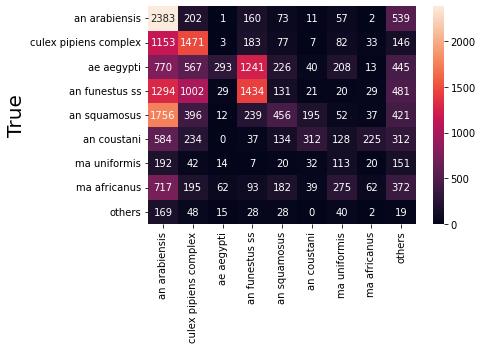

Epoch: 0, Train Loss: 1.77765908, Train Acc: 0.35836102, Val Loss: 0.00743382, Val Acc: 0.50423540, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 1batch = 0 of 812duraation = 0.06645955244700114
epoch = 1batch = 200 of 812duraation = 3.62447141011556
epoch = 1batch = 400 of 812duraation = 7.173304716746013
epoch = 1batch = 600 of 812duraation = 10.732544382413229
epoch = 1batch = 800 of 812duraation = 14.26173419157664
Saving model to: ../outputs/models/pytorch/model_e1_2022_09_18_01_07_44.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.44      0.51      9018
culex pipiens complex       0.50      0.40      0.44      4157
           ae aegypti       0.07      0.61      0.13       429
       an funestus ss       0.42      0.38      0.40      3422
         an squamosus       0.17      0.35      0.23      1327
          an coustani       0.19      0.41      0.26       657
         ma uniformis       0.18      0.30      0.22       975
         ma africanus       0.05      0.09      0.07       423
               others       0.05 

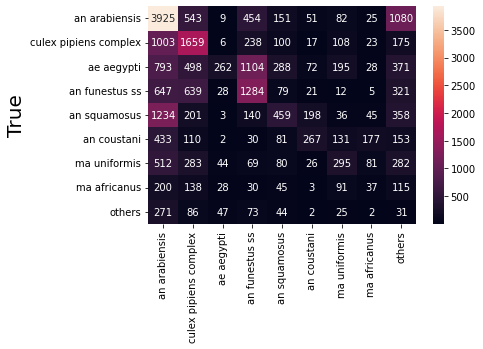

Epoch: 1, Train Loss: 1.22959995, Train Acc: 0.55767731, Val Loss: 0.00684885, Val Acc: 0.55599238, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 2batch = 0 of 812duraation = 0.06935559511184693
epoch = 2batch = 200 of 812duraation = 3.6454326152801513
epoch = 2batch = 400 of 812duraation = 7.151509575049082
epoch = 2batch = 600 of 812duraation = 10.700122853120169
epoch = 2batch = 800 of 812duraation = 14.21408684651057
Saving model to: ../outputs/models/pytorch/model_e2_2022_09_18_01_28_09.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.44      0.51      9018
culex pipiens complex       0.52      0.41      0.46      4157
           ae aegypti       0.14      0.48      0.22       429
       an funestus ss       0.41      0.55      0.47      3422
         an squamosus       0.18      0.45      0.25      1327
          an coustani       0.16      0.33      0.21       657
         ma uniformis       0.19      0.26      0.22       975
         ma africanus       0.06      0.20      0.10       423
               others       0.1

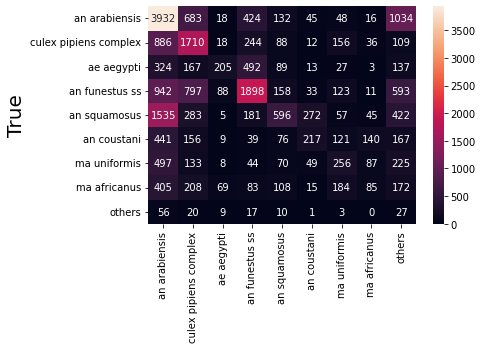

Epoch: 2, Train Loss: 1.04714360, Train Acc: 0.60646155, Val Loss: 0.00653385, Val Acc: 0.58452559, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 3batch = 0 of 812duraation = 0.06984884738922119
epoch = 3batch = 200 of 812duraation = 3.6326574246088663
epoch = 3batch = 400 of 812duraation = 7.1689403812090555
epoch = 3batch = 600 of 812duraation = 10.702271099885305
epoch = 3batch = 800 of 812duraation = 14.221355100472769
Saving model to: ../outputs/models/pytorch/model_e3_2022_09_18_01_48_33.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.43      0.51      9018
culex pipiens complex       0.42      0.51      0.46      4157
           ae aegypti       0.09      0.29      0.14       429
       an funestus ss       0.45      0.55      0.50      3422
         an squamosus       0.21      0.36      0.27      1327
          an coustani       0.19      0.34      0.25       657
         ma uniformis       0.16      0.26      0.20       975
         ma africanus       0.04      0.11      0.06       423
               others       0

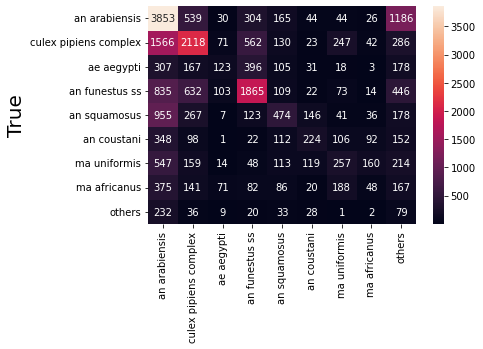

Epoch: 3, Train Loss: 0.89843598, Train Acc: 0.65108575, Val Loss: 0.00632236, Val Acc: 0.60701982, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 4batch = 0 of 812duraation = 0.06619521379470825
epoch = 4batch = 200 of 812duraation = 3.6381330569585164
epoch = 4batch = 400 of 812duraation = 7.149329884847005
epoch = 4batch = 600 of 812duraation = 10.6596950729688
epoch = 4batch = 800 of 812duraation = 14.225868479410808
Saving model to: ../outputs/models/pytorch/model_e4_2022_09_18_02_08_59.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.45      0.52      9018
culex pipiens complex       0.44      0.53      0.48      4157
           ae aegypti       0.13      0.47      0.21       429
       an funestus ss       0.44      0.57      0.50      3422
         an squamosus       0.22      0.42      0.28      1327
          an coustani       0.20      0.30      0.24       657
         ma uniformis       0.20      0.29      0.24       975
         ma africanus       0.07      0.09      0.08       423
               others       0.50

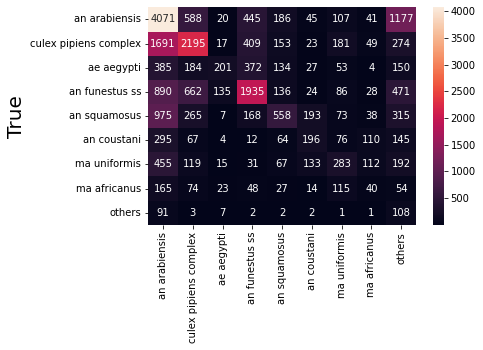

Epoch: 4, Train Loss: 0.79509212, Train Acc: 0.68261351, Val Loss: 0.00663694, Val Acc: 0.62059741, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 5batch = 0 of 812duraation = 0.06208314895629883
epoch = 5batch = 200 of 812duraation = 3.600016156832377
epoch = 5batch = 400 of 812duraation = 7.152416547139485
epoch = 5batch = 600 of 812duraation = 10.706414596239727
epoch = 5batch = 800 of 812duraation = 14.263180283705394
Saving model to: ../outputs/models/pytorch/model_e5_2022_09_18_02_29_26.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.51      0.56      9018
culex pipiens complex       0.47      0.52      0.49      4157
           ae aegypti       0.24      0.29      0.26       429
       an funestus ss       0.44      0.61      0.51      3422
         an squamosus       0.29      0.32      0.30      1327
          an coustani       0.17      0.48      0.25       657
         ma uniformis       0.26      0.31      0.28       975
         ma africanus       0.08      0.18      0.11       423
               others       0.2

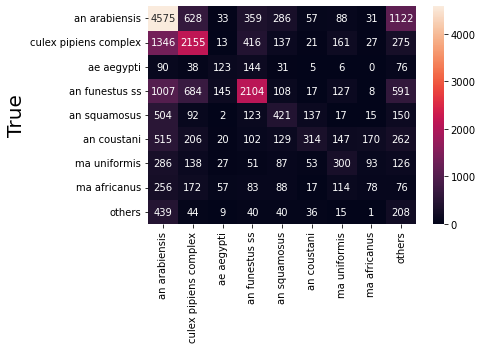

Epoch: 5, Train Loss: 0.70818982, Train Acc: 0.71393904, Val Loss: 0.00640461, Val Acc: 0.63737689, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 6batch = 0 of 812duraation = 0.06219600836435954
epoch = 6batch = 200 of 812duraation = 3.6032983024915057
epoch = 6batch = 400 of 812duraation = 7.146186228593191
epoch = 6batch = 600 of 812duraation = 10.683691871166229
epoch = 6batch = 800 of 812duraation = 14.215300341447195
Epoch: 6, Train Loss: 0.65085485, Train Acc: 0.73712745, Val Loss: 0.00675552, Val Acc: 0.63214850, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 7batch = 0 of 812duraation = 0.06633863846460979
epoch = 7batch = 200 of 812duraation = 3.6407729188601174
epoch = 7batch = 400 of 812duraation = 7.167920037110647
epoch = 7batch = 600 of 812duraation = 10.70970815817515
epoch = 7batch = 800 of 812duraation = 14.236259667078654
Epoch: 7, Train Loss: 0.59512386, Train Acc: 0.75895806, Val Loss: 0.00700266, Val Acc: 0.63522879, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 8batch = 0 of 812duraation = 0.06799985567728678
epoch = 8batch = 200 of 812duraation = 3.598694622516632
epoch = 8batch = 400 of 812duraation = 7.117533834775289
epoch = 8batch = 600 of 812duraation = 10.646407481034597
epoch = 8batch = 800 of 812duraation = 14.173052386442821
Saving model to: ../outputs/models/pytorch/model_e8_2022_09_18_03_24_19.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.60      0.56      0.58      9018
culex pipiens complex       0.42      0.58      0.49      4157
           ae aegypti       0.10      0.05      0.07       429
       an funestus ss       0.50      0.54      0.52      3422
         an squamosus       0.25      0.34      0.29      1327
          an coustani       0.15      0.17      0.16       657
         ma uniformis       0.33      0.31      0.32       975
         ma africanus       0.06      0.03      0.04       423
               others       0.2

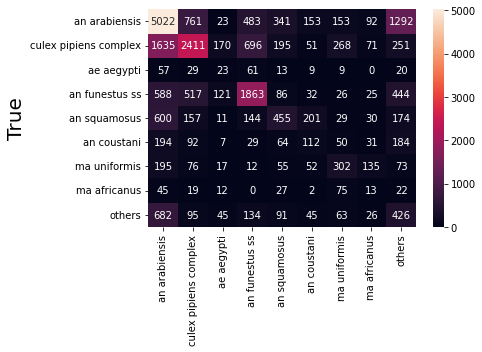

Epoch: 8, Train Loss: 0.55470099, Train Acc: 0.77198710, Val Loss: 0.00683490, Val Acc: 0.64750942, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 9batch = 0 of 812duraation = 0.0607802430788676
epoch = 9batch = 200 of 812duraation = 3.5968340754508974
epoch = 9batch = 400 of 812duraation = 7.142798058191935
epoch = 9batch = 600 of 812duraation = 10.672674902280171
epoch = 9batch = 800 of 812duraation = 14.172819566726684
Saving model to: ../outputs/models/pytorch/model_e9_2022_09_18_03_44_42.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.62      0.58      0.60      9018
culex pipiens complex       0.48      0.54      0.51      4157
           ae aegypti       0.14      0.11      0.13       429
       an funestus ss       0.45      0.61      0.52      3422
         an squamosus       0.29      0.30      0.30      1327
          an coustani       0.23      0.27      0.25       657
         ma uniformis       0.31      0.32      0.31       975
         ma africanus       0.07      0.03      0.04       423
               others       0.3

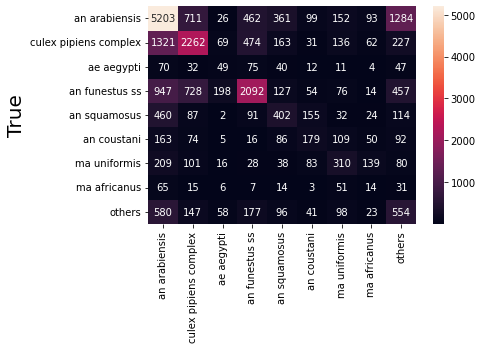

Epoch: 9, Train Loss: 0.50804848, Train Acc: 0.79260436, Val Loss: 0.00707306, Val Acc: 0.65387265, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 10batch = 0 of 812duraation = 0.06543219089508057
epoch = 10batch = 200 of 812duraation = 3.64357568025589
epoch = 10batch = 400 of 812duraation = 7.160955758889516
epoch = 10batch = 600 of 812duraation = 10.660741825898489
epoch = 10batch = 800 of 812duraation = 14.182994635899862
Epoch: 10, Train Loss: 0.49438109, Train Acc: 0.80070297, Val Loss: 0.00752874, Val Acc: 0.64353747, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 11batch = 0 of 812duraation = 0.06540764570236206
epoch = 11batch = 200 of 812duraation = 3.6156037211418153
epoch = 11batch = 400 of 812duraation = 7.1400887131690975
epoch = 11batch = 600 of 812duraation = 10.69419066508611
epoch = 11batch = 800 of 812duraation = 14.24627762635549
Saving model to: ../outputs/models/pytorch/model_e11_2022_09_18_04_22_21.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.60      0.56      0.58      9018
culex pipiens complex       0.44      0.52      0.48      4157
           ae aegypti       0.21      0.18      0.20       429
       an funestus ss       0.45      0.59      0.51      3422
         an squamosus       0.29      0.27      0.28      1327
          an coustani       0.16      0.29      0.20       657
         ma uniformis       0.24      0.26      0.25       975
         ma africanus       0.10      0.08      0.09       423
               others    

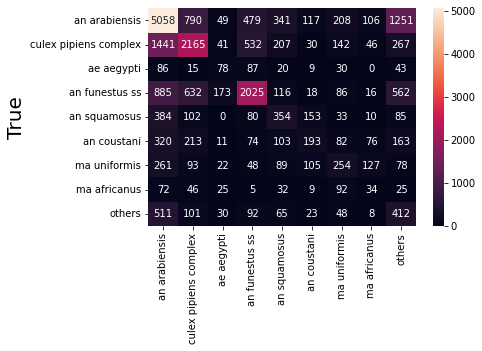

Epoch: 11, Train Loss: 0.45001655, Train Acc: 0.81821946, Val Loss: 0.00744168, Val Acc: 0.65679082, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 12batch = 0 of 812duraation = 0.06716326475143433
epoch = 12batch = 200 of 812duraation = 3.6072672526041667
epoch = 12batch = 400 of 812duraation = 7.123526724179586
epoch = 12batch = 600 of 812duraation = 10.694081970055898
epoch = 12batch = 800 of 812duraation = 14.229423399766286
Epoch: 12, Train Loss: 0.43096266, Train Acc: 0.82863884, Val Loss: 0.00767308, Val Acc: 0.65261622, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 13batch = 0 of 812duraation = 0.06958460807800293
epoch = 13batch = 200 of 812duraation = 3.6109238942464192
epoch = 13batch = 400 of 812duraation = 7.108962388833364
epoch = 13batch = 600 of 812duraation = 10.615729343891143
epoch = 13batch = 800 of 812duraation = 14.146528534094493
Saving model to: ../outputs/models/pytorch/model_e13_2022_09_18_04_59_55.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.64      0.53      0.58      9018
culex pipiens complex       0.45      0.56      0.49      4157
           ae aegypti       0.19      0.16      0.17       429
       an funestus ss       0.44      0.63      0.52      3422
         an squamosus       0.25      0.33      0.28      1327
          an coustani       0.23      0.21      0.22       657
         ma uniformis       0.29      0.37      0.33       975
         ma africanus       0.07      0.06      0.06       423
               others   

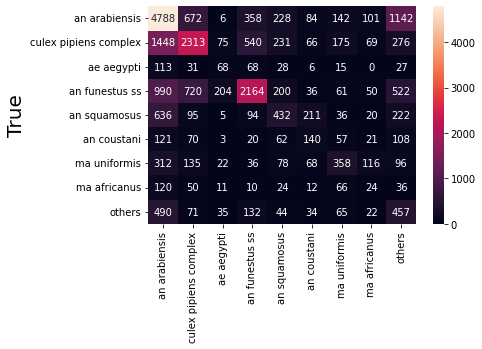

Epoch: 13, Train Loss: 0.41048320, Train Acc: 0.83543743, Val Loss: 0.00786885, Val Acc: 0.66274875, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 14batch = 0 of 812duraation = 0.06479942003885905
epoch = 14batch = 200 of 812duraation = 3.6286203503608703
epoch = 14batch = 400 of 812duraation = 7.15884569088618
epoch = 14batch = 600 of 812duraation = 10.683349418640137
epoch = 14batch = 800 of 812duraation = 14.193968991438547
Epoch: 14, Train Loss: 0.38415463, Train Acc: 0.84550051, Val Loss: 0.00825920, Val Acc: 0.64378065, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 15batch = 0 of 812duraation = 0.06623315413792928
epoch = 15batch = 200 of 812duraation = 3.5940845211346946
epoch = 15batch = 400 of 812duraation = 7.141598562399547
epoch = 15batch = 600 of 812duraation = 10.656172398726145
epoch = 15batch = 800 of 812duraation = 14.159803569316864
Epoch: 15, Train Loss: 0.37956231, Train Acc: 0.85093168, Val Loss: 0.00823572, Val Acc: 0.64613140, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 16batch = 0 of 812duraation = 0.06003286838531494
epoch = 16batch = 200 of 812duraation = 3.5996494690577188
epoch = 16batch = 400 of 812duraation = 7.143156226476034
epoch = 16batch = 600 of 812duraation = 10.654074696699778
epoch = 16batch = 800 of 812duraation = 14.174896625677745
Epoch: 16, Train Loss: 0.35888733, Train Acc: 0.85651692, Val Loss: 0.00852177, Val Acc: 0.64864427, overrun_counter 3


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 17batch = 0 of 812duraation = 0.06665476163228352
epoch = 17batch = 200 of 812duraation = 3.6007195949554442
epoch = 17batch = 400 of 812duraation = 7.123053010304769
epoch = 17batch = 600 of 812duraation = 10.63642739057541
epoch = 17batch = 800 of 812duraation = 14.169618034362793
Epoch: 17, Train Loss: 0.34664509, Train Acc: 0.86107179, Val Loss: 0.00851806, Val Acc: 0.65606128, overrun_counter 4


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 18batch = 0 of 812duraation = 0.06588454246520996
epoch = 18batch = 200 of 812duraation = 3.6176404476165773
epoch = 18batch = 400 of 812duraation = 7.139290849367778
epoch = 18batch = 600 of 812duraation = 10.686710067590077
epoch = 18batch = 800 of 812duraation = 14.199750324090322
Epoch: 18, Train Loss: 0.33787818, Train Acc: 0.86635852, Val Loss: 0.00848655, Val Acc: 0.65893892, overrun_counter 5


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 19batch = 0 of 812duraation = 0.06643120050430298
epoch = 19batch = 200 of 812duraation = 3.5886968970298767
epoch = 19batch = 400 of 812duraation = 7.138243540128072
epoch = 19batch = 600 of 812duraation = 10.672982744375865
epoch = 19batch = 800 of 812duraation = 14.203009327252706
Epoch: 19, Train Loss: 0.32887616, Train Acc: 0.86922818, Val Loss: 0.00888814, Val Acc: 0.64365906, overrun_counter 6


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 20batch = 0 of 812duraation = 0.0658754825592041
epoch = 20batch = 200 of 812duraation = 3.601681395371755
epoch = 20batch = 400 of 812duraation = 7.100137960910797
epoch = 20batch = 600 of 812duraation = 10.643521908919016
epoch = 20batch = 800 of 812duraation = 14.194478460152943
Epoch: 20, Train Loss: 0.32278496, Train Acc: 0.87201117, Val Loss: 0.00894576, Val Acc: 0.64252422, overrun_counter 7


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 21batch = 0 of 812duraation = 0.06214367548624675
epoch = 21batch = 200 of 812duraation = 3.6238246321678163
epoch = 21batch = 400 of 812duraation = 7.132005369663238
epoch = 21batch = 600 of 812duraation = 10.662804516156514
epoch = 21batch = 800 of 812duraation = 14.181844262282054
Saving model to: ../outputs/models/pytorch/model_e21_2022_09_18_07_20_38.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.59      0.64      0.61      9018
culex pipiens complex       0.49      0.49      0.49      4157
           ae aegypti       0.18      0.13      0.15       429
       an funestus ss       0.44      0.62      0.51      3422
         an squamosus       0.30      0.25      0.27      1327
          an coustani       0.28      0.30      0.29       657
         ma uniformis       0.37      0.37      0.37       975
         ma africanus       0.06      0.05      0.05       423
               others   

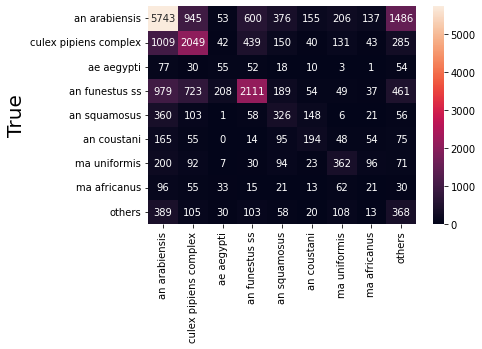

Epoch: 21, Train Loss: 0.30337201, Train Acc: 0.87752901, Val Loss: 0.00854863, Val Acc: 0.66939570, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 22batch = 0 of 812duraation = 0.0599850336710612
epoch = 22batch = 200 of 812duraation = 3.5683284918467204
epoch = 22batch = 400 of 812duraation = 7.057910386721293
epoch = 22batch = 600 of 812duraation = 10.562379582722981
epoch = 22batch = 800 of 812duraation = 14.077859139442443
Epoch: 22, Train Loss: 0.29551905, Train Acc: 0.88314315, Val Loss: 0.00913612, Val Acc: 0.64199733, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 23batch = 0 of 812duraation = 0.06629660129547119
epoch = 23batch = 200 of 812duraation = 3.590907879670461
epoch = 23batch = 400 of 812duraation = 7.116824928919474
epoch = 23batch = 600 of 812duraation = 10.636620724201203
epoch = 23batch = 800 of 812duraation = 14.167841013272604
Epoch: 23, Train Loss: 0.28899958, Train Acc: 0.88528095, Val Loss: 0.00919500, Val Acc: 0.66295140, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 24batch = 0 of 812duraation = 0.0688200831413269
epoch = 24batch = 200 of 812duraation = 3.605985673268636
epoch = 24batch = 400 of 812duraation = 7.131909465789795
epoch = 24batch = 600 of 812duraation = 10.652725644906361
epoch = 24batch = 800 of 812duraation = 14.178115777174632
Epoch: 24, Train Loss: 0.27779651, Train Acc: 0.88998989, Val Loss: 0.00885335, Val Acc: 0.66546427, overrun_counter 3


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 25batch = 0 of 812duraation = 0.06715364853541056
epoch = 25batch = 200 of 812duraation = 3.572237515449524
epoch = 25batch = 400 of 812duraation = 7.114074595769247
epoch = 25batch = 600 of 812duraation = 10.629423089822133
epoch = 25batch = 800 of 812duraation = 14.146396267414094
Epoch: 25, Train Loss: 0.27648566, Train Acc: 0.89180028, Val Loss: 0.00965527, Val Acc: 0.65756090, overrun_counter 4


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 26batch = 0 of 812duraation = 0.05968089898427328
epoch = 26batch = 200 of 812duraation = 3.5832191109657288
epoch = 26batch = 400 of 812duraation = 7.114437131086985
epoch = 26batch = 600 of 812duraation = 10.623878105481465
epoch = 26batch = 800 of 812duraation = 14.155003849665324
Epoch: 26, Train Loss: 0.27829580, Train Acc: 0.89064471, Val Loss: 0.00917952, Val Acc: 0.66282981, overrun_counter 5


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 27batch = 0 of 812duraation = 0.06892160177230836
epoch = 27batch = 200 of 812duraation = 3.6030062675476073
epoch = 27batch = 400 of 812duraation = 7.125801507631937
epoch = 27batch = 600 of 812duraation = 10.643591618537902
epoch = 27batch = 800 of 812duraation = 14.137597942352295
Epoch: 27, Train Loss: 0.26817836, Train Acc: 0.89392845, Val Loss: 0.00872149, Val Acc: 0.66611275, overrun_counter 6


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 28batch = 0 of 812duraation = 0.06885246435801189
epoch = 28batch = 200 of 812duraation = 3.5887420376141868
epoch = 28batch = 400 of 812duraation = 7.099886425336202
epoch = 28batch = 600 of 812duraation = 10.641168908278148
epoch = 28batch = 800 of 812duraation = 14.149879829088848
Saving model to: ../outputs/models/pytorch/model_e28_2022_09_18_09_23_51.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.60      0.65      0.62      9018
culex pipiens complex       0.47      0.48      0.47      4157
           ae aegypti       0.18      0.20      0.19       429
       an funestus ss       0.46      0.54      0.50      3422
         an squamosus       0.33      0.27      0.30      1327
          an coustani       0.31      0.30      0.31       657
         ma uniformis       0.29      0.40      0.33       975
         ma africanus       0.06      0.02      0.03       423
               others   

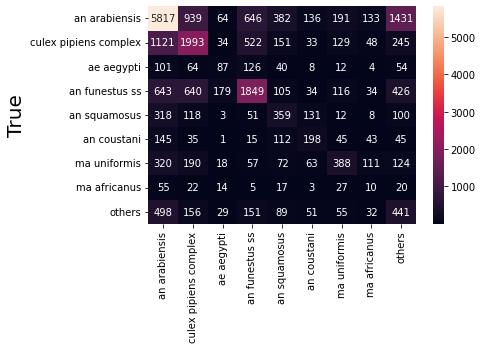

Epoch: 28, Train Loss: 0.25532656, Train Acc: 0.89819442, Val Loss: 0.00940032, Val Acc: 0.67117902, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 29batch = 0 of 812duraation = 0.07163005669911703
epoch = 29batch = 200 of 812duraation = 3.5945423364639284
epoch = 29batch = 400 of 812duraation = 7.099898103872935
epoch = 29batch = 600 of 812duraation = 10.607122461001078
epoch = 29batch = 800 of 812duraation = 14.129170517126719
Saving model to: ../outputs/models/pytorch/model_e29_2022_09_18_09_44_08.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.61      0.60      0.60      9018
culex pipiens complex       0.45      0.50      0.48      4157
           ae aegypti       0.14      0.14      0.14       429
       an funestus ss       0.44      0.63      0.52      3422
         an squamosus       0.31      0.27      0.29      1327
          an coustani       0.18      0.22      0.20       657
         ma uniformis       0.41      0.31      0.36       975
         ma africanus       0.07      0.03      0.04       423
               others   

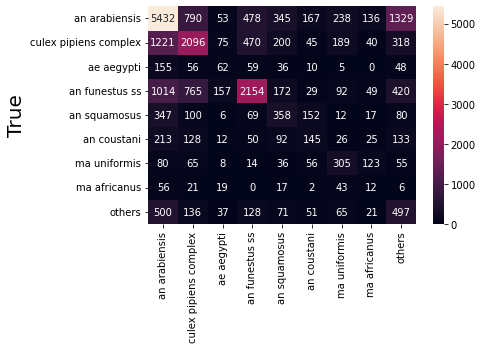

Epoch: 29, Train Loss: 0.25348100, Train Acc: 0.90146853, Val Loss: 0.00907787, Val Acc: 0.67588052, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 30batch = 0 of 812duraation = 0.06521965662638346
epoch = 30batch = 200 of 812duraation = 3.608559230963389
epoch = 30batch = 400 of 812duraation = 7.074053271611532
epoch = 30batch = 600 of 812duraation = 10.615303881963094
epoch = 30batch = 800 of 812duraation = 14.135050292809805
Epoch: 30, Train Loss: 0.24574231, Train Acc: 0.90349078, Val Loss: 0.00883427, Val Acc: 0.67361083, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 31batch = 0 of 812duraation = 0.07062919934590657
epoch = 31batch = 200 of 812duraation = 3.5835275689760846
epoch = 31batch = 400 of 812duraation = 7.09203473329544
epoch = 31batch = 600 of 812duraation = 10.594080662727356
epoch = 31batch = 800 of 812duraation = 14.11160992383957
Epoch: 31, Train Loss: 0.24495692, Train Acc: 0.90406856, Val Loss: 0.00925535, Val Acc: 0.66862562, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 32batch = 0 of 812duraation = 0.06544180313746134
epoch = 32batch = 200 of 812duraation = 3.5957536180814107
epoch = 32batch = 400 of 812duraation = 7.106006042162577
epoch = 32batch = 600 of 812duraation = 10.646325647830963
epoch = 32batch = 800 of 812duraation = 14.185649279753367
Epoch: 32, Train Loss: 0.23819728, Train Acc: 0.90661081, Val Loss: 0.00915957, Val Acc: 0.67308394, overrun_counter 3


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 33batch = 0 of 812duraation = 0.06596269210179646
epoch = 33batch = 200 of 812duraation = 3.61956574122111
epoch = 33batch = 400 of 812duraation = 7.138489385445912
epoch = 33batch = 600 of 812duraation = 10.65477421283722
epoch = 33batch = 800 of 812duraation = 14.156830457846324
Epoch: 33, Train Loss: 0.23958464, Train Acc: 0.90701526, Val Loss: 0.00980904, Val Acc: 0.66708548, overrun_counter 4


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 34batch = 0 of 812duraation = 0.05987412134806315
epoch = 34batch = 200 of 812duraation = 3.58811772664388
epoch = 34batch = 400 of 812duraation = 7.112347634633382
epoch = 34batch = 600 of 812duraation = 10.631129018465678
epoch = 34batch = 800 of 812duraation = 14.131925682226816
Epoch: 34, Train Loss: 0.22329402, Train Acc: 0.91084790, Val Loss: 0.00947356, Val Acc: 0.67312447, overrun_counter 5


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 35batch = 0 of 812duraation = 0.07138015031814575
epoch = 35batch = 200 of 812duraation = 3.610367492834727
epoch = 35batch = 400 of 812duraation = 7.114335823059082
epoch = 35batch = 600 of 812duraation = 10.627863013744355
epoch = 35batch = 800 of 812duraation = 14.16720456679662
Saving model to: ../outputs/models/pytorch/model_e35_2022_09_18_11_30_07.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.59      0.60      0.60      9018
culex pipiens complex       0.47      0.48      0.48      4157
           ae aegypti       0.29      0.17      0.21       429
       an funestus ss       0.41      0.62      0.50      3422
         an squamosus       0.31      0.26      0.28      1327
          an coustani       0.19      0.13      0.15       657
         ma uniformis       0.32      0.28      0.30       975
         ma africanus       0.18      0.07      0.10       423
               others     

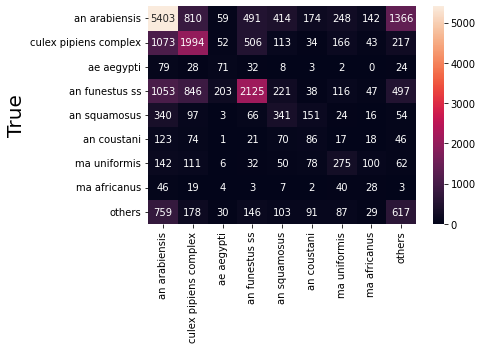

Epoch: 35, Train Loss: 0.23074717, Train Acc: 0.90874862, Val Loss: 0.00916939, Val Acc: 0.67997406, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 36batch = 0 of 812duraation = 0.06547694206237793
epoch = 36batch = 200 of 812duraation = 3.582205597559611
epoch = 36batch = 400 of 812duraation = 7.1052369475364685
epoch = 36batch = 600 of 812duraation = 10.634964883327484
epoch = 36batch = 800 of 812duraation = 14.150074597199758
Epoch: 36, Train Loss: 0.22072075, Train Acc: 0.91253310, Val Loss: 0.00955251, Val Acc: 0.67292182, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 37batch = 0 of 812duraation = 0.06315838098526001
epoch = 37batch = 200 of 812duraation = 3.5892704645792644
epoch = 37batch = 400 of 812duraation = 7.098271934191386
epoch = 37batch = 600 of 812duraation = 10.636571574211121
epoch = 37batch = 800 of 812duraation = 14.156507953008015
Epoch: 37, Train Loss: 0.22252332, Train Acc: 0.91273533, Val Loss: 0.00958543, Val Acc: 0.67344871, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 38batch = 0 of 812duraation = 0.06967190106709799
epoch = 38batch = 200 of 812duraation = 3.5925992727279663
epoch = 38batch = 400 of 812duraation = 7.117142975330353
epoch = 38batch = 600 of 812duraation = 10.629104765256246
epoch = 38batch = 800 of 812duraation = 14.142134654521943
Epoch: 38, Train Loss: 0.21871869, Train Acc: 0.91366941, Val Loss: 0.00951471, Val Acc: 0.67774490, overrun_counter 3


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 39batch = 0 of 812duraation = 0.06340103149414063
epoch = 39batch = 200 of 812duraation = 3.5805297017097475
epoch = 39batch = 400 of 812duraation = 7.076874677340189
epoch = 39batch = 600 of 812duraation = 10.598196017742158
epoch = 39batch = 800 of 812duraation = 14.119537063439687
Epoch: 39, Train Loss: 0.20866362, Train Acc: 0.91771390, Val Loss: 0.01009810, Val Acc: 0.67275970, overrun_counter 4


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 40batch = 0 of 812duraation = 0.0630378524462382
epoch = 40batch = 200 of 812duraation = 3.6111019690831503
epoch = 40batch = 400 of 812duraation = 7.1037911375363665
epoch = 40batch = 600 of 812duraation = 10.611718885103862
epoch = 40batch = 800 of 812duraation = 14.144167224566141
Epoch: 40, Train Loss: 0.21068811, Train Acc: 0.91605759, Val Loss: 0.00956413, Val Acc: 0.66627488, overrun_counter 5


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 41batch = 0 of 812duraation = 0.06882414420445761
epoch = 41batch = 200 of 812duraation = 3.6212539116541547
epoch = 41batch = 400 of 812duraation = 7.143614113330841
epoch = 41batch = 600 of 812duraation = 10.65417376756668
epoch = 41batch = 800 of 812duraation = 14.185729777812957
Epoch: 41, Train Loss: 0.20462002, Train Acc: 0.91780057, Val Loss: 0.00915543, Val Acc: 0.67280023, overrun_counter 6


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 42batch = 0 of 812duraation = 0.0651578426361084
epoch = 42batch = 200 of 812duraation = 3.5897650718688965
epoch = 42batch = 400 of 812duraation = 7.131247242291768
epoch = 42batch = 600 of 812duraation = 10.62470364967982
epoch = 42batch = 800 of 812duraation = 14.139701894919078
Saving model to: ../outputs/models/pytorch/model_e42_2022_09_18_13_33_18.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.58      0.62      0.60      9018
culex pipiens complex       0.46      0.50      0.48      4157
           ae aegypti       0.20      0.19      0.19       429
       an funestus ss       0.46      0.60      0.52      3422
         an squamosus       0.31      0.25      0.28      1327
          an coustani       0.28      0.18      0.22       657
         ma uniformis       0.54      0.31      0.40       975
         ma africanus       0.05      0.02      0.03       423
               others     

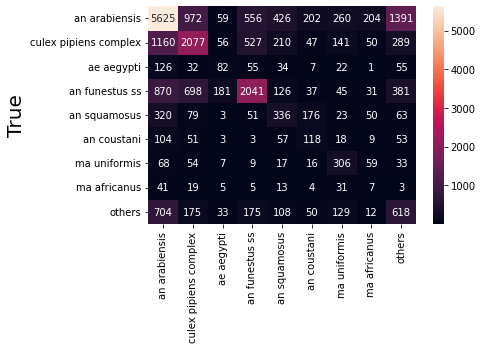

Epoch: 42, Train Loss: 0.19851189, Train Acc: 0.92029467, Val Loss: 0.00994613, Val Acc: 0.68118996, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 43batch = 0 of 812duraation = 0.0651967167854309
epoch = 43batch = 200 of 812duraation = 3.5867721756299336
epoch = 43batch = 400 of 812duraation = 7.1270941654841105
epoch = 43batch = 600 of 812duraation = 10.660358448823294
epoch = 43batch = 800 of 812duraation = 14.163110911846161
Epoch: 43, Train Loss: 0.19741969, Train Acc: 0.92054504, Val Loss: 0.00982639, Val Acc: 0.66753131, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 44batch = 0 of 812duraation = 0.06298917531967163
epoch = 44batch = 200 of 812duraation = 3.605833693345388
epoch = 44batch = 400 of 812duraation = 7.123428054650625
epoch = 44batch = 600 of 812duraation = 10.636763719717662
epoch = 44batch = 800 of 812duraation = 14.152772462368011
Epoch: 44, Train Loss: 0.20521958, Train Acc: 0.91799316, Val Loss: 0.00951769, Val Acc: 0.67916346, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 45batch = 0 of 812duraation = 0.05911247730255127
epoch = 45batch = 200 of 812duraation = 3.580203914642334
epoch = 45batch = 400 of 812duraation = 7.1190699179967245
epoch = 45batch = 600 of 812duraation = 10.618388108412425
epoch = 45batch = 800 of 812duraation = 14.151566712061564
Epoch: 45, Train Loss: 0.19482160, Train Acc: 0.92277914, Val Loss: 0.00992069, Val Acc: 0.66072225, overrun_counter 3


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 46batch = 0 of 812duraation = 0.07050445079803466
epoch = 46batch = 200 of 812duraation = 3.596805532773336
epoch = 46batch = 400 of 812duraation = 7.1223057826360066
epoch = 46batch = 600 of 812duraation = 10.636815921465557
epoch = 46batch = 800 of 812duraation = 14.142858401934307
Saving model to: ../outputs/models/pytorch/model_e46_2022_09_18_14_45_03.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.58      0.71      0.64      9018
culex pipiens complex       0.49      0.50      0.50      4157
           ae aegypti       0.24      0.13      0.17       429
       an funestus ss       0.46      0.59      0.52      3422
         an squamosus       0.40      0.19      0.26      1327
          an coustani       0.27      0.28      0.28       657
         ma uniformis       0.42      0.38      0.40       975
         ma africanus       0.08      0.03      0.04       423
               others   

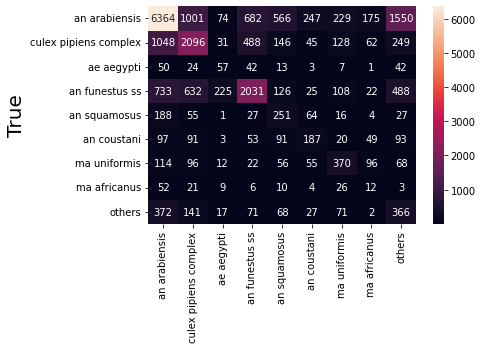

Epoch: 46, Train Loss: 0.18993410, Train Acc: 0.92559103, Val Loss: 0.01051437, Val Acc: 0.68127103, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 47batch = 0 of 812duraation = 0.06386364301045735
epoch = 47batch = 200 of 812duraation = 3.651243734359741
epoch = 47batch = 400 of 812duraation = 7.168975222110748
epoch = 47batch = 600 of 812duraation = 10.65543762842814
epoch = 47batch = 800 of 812duraation = 14.195658047993978
Epoch: 47, Train Loss: 0.18416039, Train Acc: 0.92510954, Val Loss: 0.01056471, Val Acc: 0.64544239, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 48batch = 0 of 812duraation = 0.06640157699584961
epoch = 48batch = 200 of 812duraation = 3.5942101160685223
epoch = 48batch = 400 of 812duraation = 7.134722292423248
epoch = 48batch = 600 of 812duraation = 10.621945854028066
epoch = 48batch = 800 of 812duraation = 14.153357330958048
Epoch: 48, Train Loss: 0.19270138, Train Acc: 0.92352063, Val Loss: 0.01009797, Val Acc: 0.67198962, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 49batch = 0 of 812duraation = 0.06583633025487264
epoch = 49batch = 200 of 812duraation = 3.5997233271598814
epoch = 49batch = 400 of 812duraation = 7.110302293300629
epoch = 49batch = 600 of 812duraation = 10.632288531462352
epoch = 49batch = 800 of 812duraation = 14.160393905639648
Epoch: 49, Train Loss: 0.18893289, Train Acc: 0.92506139, Val Loss: 0.01000980, Val Acc: 0.67320553, overrun_counter 3


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 50batch = 0 of 812duraation = 0.06493759552637736
epoch = 50batch = 200 of 812duraation = 3.5548014044761658
epoch = 50batch = 400 of 812duraation = 7.039014232158661
epoch = 50batch = 600 of 812duraation = 10.583160654703777
epoch = 50batch = 800 of 812duraation = 14.076448071002961
Epoch: 50, Train Loss: 0.17057668, Train Acc: 0.93124368, Val Loss: 0.01052346, Val Acc: 0.66424837, overrun_counter 4


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 51batch = 0 of 812duraation = 0.06741838057835897
epoch = 51batch = 200 of 812duraation = 3.6179031213124593
epoch = 51batch = 400 of 812duraation = 7.132003764311473
epoch = 51batch = 600 of 812duraation = 10.639454583326975
epoch = 51batch = 800 of 812duraation = 14.161024828751883
Epoch: 51, Train Loss: 0.18065173, Train Acc: 0.92700660, Val Loss: 0.01009681, Val Acc: 0.67320553, overrun_counter 5


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 52batch = 0 of 812duraation = 0.06780315240224202
epoch = 52batch = 200 of 812duraation = 3.649294050534566
epoch = 52batch = 400 of 812duraation = 7.2159704248110454
epoch = 52batch = 600 of 812duraation = 10.752388501167298
epoch = 52batch = 800 of 812duraation = 14.294985294342041
Epoch: 52, Train Loss: 0.18039176, Train Acc: 0.92741105, Val Loss: 0.00989001, Val Acc: 0.66477526, overrun_counter 6


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 53batch = 0 of 812duraation = 0.06683687766393026
epoch = 53batch = 200 of 812duraation = 3.6429873863855997
epoch = 53batch = 400 of 812duraation = 7.169542694091797
epoch = 53batch = 600 of 812duraation = 10.681352937221527
epoch = 53batch = 800 of 812duraation = 14.177354323863984
Epoch: 53, Train Loss: 0.17369327, Train Acc: 0.93089701, Val Loss: 0.00956200, Val Acc: 0.67223281, overrun_counter 7


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 54batch = 0 of 812duraation = 0.06251960595448812
epoch = 54batch = 200 of 812duraation = 3.614001202583313
epoch = 54batch = 400 of 812duraation = 7.121830117702484
epoch = 54batch = 600 of 812duraation = 10.642928342024485
epoch = 54batch = 800 of 812duraation = 14.182596707344056
Epoch: 54, Train Loss: 0.17601619, Train Acc: 0.92812365, Val Loss: 0.00994269, Val Acc: 0.67989300, overrun_counter 8


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 55batch = 0 of 812duraation = 0.06518035729726156
epoch = 55batch = 200 of 812duraation = 3.5850913087526957
epoch = 55batch = 400 of 812duraation = 7.102217324574789
epoch = 55batch = 600 of 812duraation = 10.6166250983874
epoch = 55batch = 800 of 812duraation = 14.130975472927094
Epoch: 55, Train Loss: 0.17501144, Train Acc: 0.93003996, Val Loss: 0.00949083, Val Acc: 0.68033883, overrun_counter 9


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 56batch = 0 of 812duraation = 0.0632274587949117
epoch = 56batch = 200 of 812duraation = 3.6000779986381533
epoch = 56batch = 400 of 812duraation = 7.117021977901459
epoch = 56batch = 600 of 812duraation = 10.648918151855469
epoch = 56batch = 800 of 812duraation = 14.18478061358134
Epoch: 56, Train Loss: 0.16654973, Train Acc: 0.93219702, Val Loss: 0.01017664, Val Acc: 0.66785555, overrun_counter 10


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 57batch = 0 of 812duraation = 0.06841310660044352
epoch = 57batch = 200 of 812duraation = 3.6376585523287455
epoch = 57batch = 400 of 812duraation = 7.171607561906179
epoch = 57batch = 600 of 812duraation = 10.697816487153371
epoch = 57batch = 800 of 812duraation = 14.224898405869801
Saving model to: ../outputs/models/pytorch/model_e57_2022_09_18_17_57_14.pth
Now printing classification rport... 
                       precision    recall  f1-score   support

        an arabiensis       0.59      0.64      0.61      9018
culex pipiens complex       0.48      0.48      0.48      4157
           ae aegypti       0.18      0.20      0.19       429
       an funestus ss       0.46      0.60      0.52      3422
         an squamosus       0.30      0.25      0.27      1327
          an coustani       0.27      0.22      0.24       657
         ma uniformis       0.45      0.29      0.35       975
         ma africanus       0.07      0.05      0.06       423
               others   

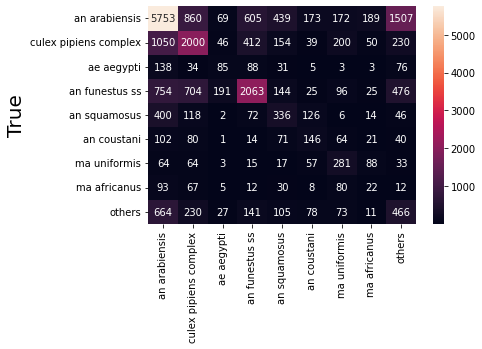

Epoch: 57, Train Loss: 0.16686197, Train Acc: 0.93244740, Val Loss: 0.01057836, Val Acc: 0.68204110, overrun_counter 0


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 58batch = 0 of 812duraation = 0.0648168961207072
epoch = 58batch = 200 of 812duraation = 3.570204186439514
epoch = 58batch = 400 of 812duraation = 7.075136554241181
epoch = 58batch = 600 of 812duraation = 10.587902243932088
epoch = 58batch = 800 of 812duraation = 14.114612674713134
Epoch: 58, Train Loss: 0.16100367, Train Acc: 0.93390149, Val Loss: 0.01003439, Val Acc: 0.67981194, overrun_counter 1


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 59batch = 0 of 812duraation = 0.0627509593963623
epoch = 59batch = 200 of 812duraation = 3.6283929427464803
epoch = 59batch = 400 of 812duraation = 7.134727982680003
epoch = 59batch = 600 of 812duraation = 10.65930704275767
epoch = 59batch = 800 of 812duraation = 14.170094553629557
Epoch: 59, Train Loss: 0.16389717, Train Acc: 0.93315037, Val Loss: 0.01047970, Val Acc: 0.66874721, overrun_counter 2


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 60batch = 0 of 812duraation = 0.06656713485717773
epoch = 60batch = 200 of 812duraation = 3.6088218530019125
epoch = 60batch = 400 of 812duraation = 7.1193050424257915
epoch = 60batch = 600 of 812duraation = 10.641276307900746
epoch = 60batch = 800 of 812duraation = 14.167472525437672
Epoch: 60, Train Loss: 0.15814655, Train Acc: 0.93404593, Val Loss: 0.01029700, Val Acc: 0.67097637, overrun_counter 3


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 61batch = 0 of 812duraation = 0.059152992566426595
epoch = 61batch = 200 of 812duraation = 3.5994404276212055
epoch = 61batch = 400 of 812duraation = 7.111104679107666
epoch = 61batch = 600 of 812duraation = 10.639336542288463
epoch = 61batch = 800 of 812duraation = 14.219497962792714
Epoch: 61, Train Loss: 0.16008001, Train Acc: 0.93498965, Val Loss: 0.01035774, Val Acc: 0.67203015, overrun_counter 4


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 62batch = 0 of 812duraation = 0.06215662558873494
epoch = 62batch = 200 of 812duraation = 3.628211732705434
epoch = 62batch = 400 of 812duraation = 7.130072236061096
epoch = 62batch = 600 of 812duraation = 10.666886488596598
epoch = 62batch = 800 of 812duraation = 14.186609649658203
Epoch: 62, Train Loss: 0.15256776, Train Acc: 0.93794598, Val Loss: 0.01054258, Val Acc: 0.66493738, overrun_counter 5


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 63batch = 0 of 812duraation = 0.05710547765096029
epoch = 63batch = 200 of 812duraation = 3.6379287242889404
epoch = 63batch = 400 of 812duraation = 7.159102805455526
epoch = 63batch = 600 of 812duraation = 10.677941449483235
epoch = 63batch = 800 of 812duraation = 14.198129252592723
Epoch: 63, Train Loss: 0.15933535, Train Acc: 0.93712745, Val Loss: 0.01008298, Val Acc: 0.67235440, overrun_counter 6


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 64batch = 0 of 812duraation = 0.07167517344156901
epoch = 64batch = 200 of 812duraation = 3.639054465293884
epoch = 64batch = 400 of 812duraation = 7.168236955006917
epoch = 64batch = 600 of 812duraation = 10.716169035434723
epoch = 64batch = 800 of 812duraation = 14.228281855583191
Epoch: 64, Train Loss: 0.15475357, Train Acc: 0.93694448, Val Loss: 0.00996335, Val Acc: 0.68078466, overrun_counter 7


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 65batch = 0 of 812duraation = 0.06840072870254517
epoch = 65batch = 200 of 812duraation = 3.5869410634040833
epoch = 65batch = 400 of 812duraation = 7.12415585120519
epoch = 65batch = 600 of 812duraation = 10.660348999500275
epoch = 65batch = 800 of 812duraation = 14.174991957346599
Epoch: 65, Train Loss: 0.14877894, Train Acc: 0.94002600, Val Loss: 0.01087634, Val Acc: 0.66886880, overrun_counter 8


  0%|          | 0/812 [00:00<?, ?it/s]

epoch = 66batch = 0 of 812duraation = 0.07058001359303792
epoch = 66batch = 200 of 812duraation = 3.604265876611074
epoch = 66batch = 400 of 812duraation = 7.105039664109548


KeyboardInterrupt: 

In [63]:
model =Model('convnext_small',224)

model, lr_log = train_model(train_loader, val_loader, test_loader,model, classes ,class_weights ,num_epochs = num_epochs )

In [ ]:
prediction  = [2.0, 3.0, 8.0, 2.0, 8.0, 8.0, 4.0, 0.0, 7.0, 8.0, 8.0, 2.0, 8.0, 0.0, 1.0, 3.0, 4.0, 8.0, 5.0, 8.0, 2.0, 2.0, 2.0, 0.0, 5.0, 5.0, 3.0, 8.0, 4.0, 1.0, 2.0, 5.0, 6.0, 1.0, 8.0, 0.0, 2.0, 4.0, 6.0, 8.0, 7.0, 0.0, 7.0, 0.0, 8.0, 5.0, 8.0, 2.0, 0.0, 0.0, 4.0, 7.0, 5.0, 4.0, 1.0, 2.0, 4.0, 1.0, 6.0, 4.0, 3.0, 7.0, 8.0, 8.0, 0.0, 6.0, 7.0, 1.0, 6.0, 5.0, 7.0, 0.0, 5.0, 0.0, 0.0, 2.0, 1.0, 5.0, 8.0, 1.0, 5.0, 7.0, 5.0, 7.0, 3.0, 6.0, 6.0, 6.0, 2.0, 6.0, 2.0, 6.0, 6.0, 3.0, 6.0, 6.0, 0.0, 4.0, 6.0, 6.0, 0.0, 8.0, 7.0, 1.0, 4.0, 1.0, 3.0, 0.0, 8.0, 6.0, 5.0, 7.0, 7.0, 3.0, 2.0, 0.0, 4.0, 3.0, 4.0, 2.0, 4.0, 2.0, 7.0, 3.0, 1.0, 3.0, 6.0, 5.0, 5.0, 2.0, 0.0, 2.0, 0.0, 6.0, 3.0, 0.0, 3.0, 4.0, 8.0, 6.0, 4.0, 6.0, 0.0, 4.0, 5.0, 2.0, 6.0, 1.0, 1.0, 5.0, 4.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0, 4.0, 4.0, 8.0, 8.0, 5.0, 5.0, 0.0, 1.0, 3.0, 3.0, 7.0, 7.0, 1.0, 5.0, 7.0, 6.0, 5.0, 8.0, 3.0, 8.0, 5.0, 2.0, 3.0, 7.0, 3.0, 7.0, 8.0, 4.0, 2.0, 0.0, 6.0, 8.0, 1.0, 3.0, 6.0, 2.0, 2.0, 7.0, 7.0, 2.0, 0.0, 4.0, 8.0]
Label   = [3.0, 5.0, 0.0, 0.0, 2.0, 0.0, 1.0, 3.0, 4.0, 7.0, 1.0, 3.0, 2.0, 1.0, 4.0, 1.0, 3.0, 8.0, 8.0, 8.0, 3.0, 4.0, 7.0, 6.0, 4.0, 1.0, 3.0, 0.0, 7.0, 7.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 4.0, 2.0, 8.0, 8.0, 7.0, 4.0, 7.0, 2.0, 6.0, 1.0, 8.0, 4.0, 8.0, 0.0, 1.0, 4.0, 2.0, 2.0, 0.0, 8.0, 1.0, 7.0, 4.0, 1.0, 2.0, 1.0, 2.0, 3.0, 6.0, 3.0, 6.0, 5.0, 4.0, 0.0, 5.0, 8.0, 5.0, 7.0, 1.0, 1.0, 6.0, 8.0, 6.0, 6.0, 4.0, 6.0, 6.0, 6.0, 8.0, 4.0, 5.0, 8.0, 0.0, 7.0, 4.0, 1.0, 6.0, 1.0, 5.0, 5.0, 5.0, 3.0, 8.0, 7.0, 8.0, 1.0, 2.0, 7.0, 2.0, 0.0, 4.0, 3.0, 2.0, 5.0, 1.0, 1.0, 2.0, 3.0, 0.0, 4.0, 7.0, 5.0, 2.0, 2.0, 6.0, 7.0, 2.0, 2.0, 6.0, 4.0, 2.0, 5.0, 8.0, 3.0, 6.0, 1.0, 1.0, 6.0, 5.0, 0.0, 2.0, 5.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 1.0, 4.0, 3.0, 0.0, 6.0, 3.0, 7.0, 1.0, 2.0, 7.0, 3.0, 6.0, 1.0, 3.0, 8.0, 3.0, 6.0, 1.0, 4.0, 4.0, 6.0, 2.0, 5.0, 3.0, 0.0, 5.0, 7.0, 3.0, 5.0, 6.0, 4.0, 7.0, 1.0, 1.0, 6.0, 1.0, 4.0, 5.0, 8.0, 4.0, 6.0, 4.0, 5.0, 1.0, 6.0, 0.0, 3.0, 3.0, 3.0, 4.0, 7.0, 5.0, 2.0, 6.0, 2.0, 4.0]
print(classification_report(np.array(Label), np.array(prediction), target_names= classes))
from sklearn.metrics import confusion_matrix
classes
cm = confusion_matrix(prediction, Label ,labels= range(0,9))
print(cm)
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
ax.xaxis.set_ticklabels(classes, fontsize = 10)
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(classes, fontsize = 10)
plt.yticks(rotation=0)

In [ ]:
label = []
pred = []
for i in range(10):
    label.append(np.random.rand(9))
    pred.append(np.random.rand(9))
print(label)
print(pred)
print(classification_report(label, pred, target_names= classes, labels= classes))

In [ ]:
label = torch.tensor(8, device = "cuda")
print(label)
label_cpu = label.cpu().detach()
print(label_cpu)
label_np = label_cpu.numpy()
print(type(label_np))
label_np_item = label_np.item()
print(type(label_np_item))




In [ ]:
y_pred = torch.randn(4,9)
y_pred.shape
#y_pred_np = y_pred.numpy()

In [ ]:
# y_pred_np
# y_pred_np.shape

In [ ]:
preds = torch.argmax(y_pred, axis = 1)

In [ ]:
preds.shape

In [ ]:
print(preds)

In [ ]:
for idx,(x,y) in enumerate(test_loader):
    print("idx = " + str(idx))